In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Polygon
from tqdm import tqdm 

from src.objects import Rectangle, Circle, Triangle, DoubleRectangle, draw_grid


# Simulate in Rectangle

In [12]:
# Initialize rectangle scene
width = 9
height = 9
rectangle_scene = Rectangle(width=width, height=height, vertical_gravity=600.0, restitution=0.8)
#rectangle_scene = Rectangle(width=width, height=height, vertical_gravity=0.0, restitution=1.0)

# Generate particles
num_particles = 1000
radius_range = (0.125, 0.125)
density_range = (1.0, 1.0)

# Add particles to the rectangle scene
rectangle_scene.generate_particles(num_particles=num_particles, 
                                   radius_range=radius_range, 
                                   density_range=density_range,
                                   speed_scaling=15)

[WARNING]: only managed to fit 789 in rectangle


In [13]:
# Simulation parameters
n_steps = 6000
dt = 0.0001

for _ in tqdm(range(n_steps)):
    rectangle_scene.simulate(1, dt)

  0%|          | 0/6000 [00:00<?, ?it/s]

  6%|▋         | 382/6000 [00:21<05:10, 18.11it/s]


KeyboardInterrupt: 

303it [00:31,  9.70it/s]                         


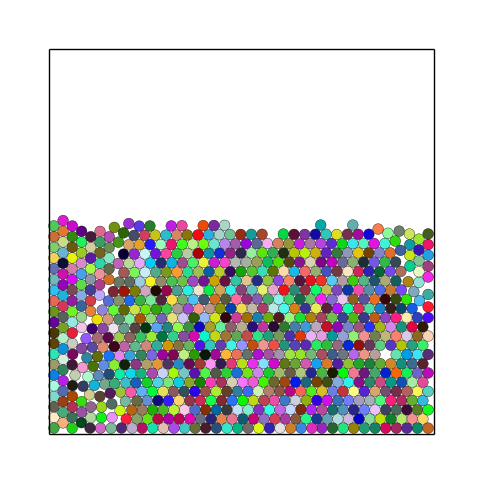

In [21]:
# New parameter to control frame skipping
skip_frames = 20  # Change this value to skip frames (e.g., 2 to skip every other frame). Makes animation speed up

# Prepare the figure and axes for plotting
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
factor = 0.1
ax.set_xlim(0 - factor * width, width + factor * width)
ax.set_ylim(0 - factor * height, height + factor * height)

# Draw rectangle (walls)
wall_width = 1
ax.hlines(y=height, xmin=0, xmax=width, ls='-', lw=wall_width, color='black')
ax.hlines(y=0, xmin=0, xmax=width, ls='-', lw=wall_width, color='black')
ax.vlines(x=0, ymin=0, ymax=height, ls='-', lw=wall_width, color='black')
ax.vlines(x=width, ymin=0, ymax=height, ls='-', lw=wall_width, color='black')

# Add partitioning grid to scene
#draw_grid(ax=ax, scene_obj=rectangle_scene)

# Create Circle patches for the particles
circles = []
for particle in rectangle_scene.particles:
    circle = plt.Circle(particle.position, particle.radius, facecolor=particle.color, edgecolor='black', linewidth = 0.25, fill=True)
    ax.add_patch(circle)
    circles.append(circle)

ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal', 'box')
plt.axis('off')

# Adjust the number of frames based on the skip_frames parameter
adjusted_n_steps = n_steps // skip_frames

pbar = tqdm(total=adjusted_n_steps)
# Update function for the animation
def update(frame):
    # Adjust frame based on skip_frames
    frame = frame * skip_frames

    # For each particle, get the position from its path_history at the adjusted frame
    for i, particle in enumerate(rectangle_scene.particles):
        if frame < len(particle.path_history):  # Ensure the frame doesn't exceed path_history length
            circles[i].center = particle.path_history[frame]  # Update position from path_history

    pbar.update(1)
    return circles


# Create the animation
ani = FuncAnimation(fig, update, frames=adjusted_n_steps, interval=30, blit=True)

# Save animation to file (optional)
ani.save(filename="examples/gravity_rectangle_particle_simulation.gif", writer='pillow', dpi=200)

pbar.close()

# Simulate in Circle

In [31]:
# Initialize circle scene
scene_radius = 4.5
#circle_scene = Circle(radius=scene_radius, vertical_gravity=0.0, restitution=1.0)
circle_scene = Circle(radius=scene_radius, vertical_gravity=600.0, restitution=0.8)

# Generate particles
num_particles = 800
radius_range = (0.1, 0.1)
density_range = (1.0, 1.0)

# Add particles to the circle scene
circle_scene.generate_particles(num_particles=num_particles, 
                                radius_range=radius_range, 
                                density_range=density_range,
                                speed_scaling=15)

In [32]:
# Simulation parameters
n_steps = 6000
dt = 0.0001

# Simulate the scene
for _ in tqdm(range(n_steps)):
    circle_scene.simulate(1, dt)

100%|██████████| 6000/6000 [26:25<00:00,  3.78it/s]


303it [00:30,  9.78it/s]                         


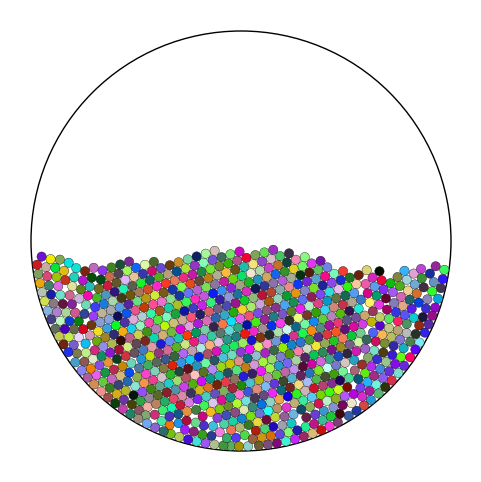

In [33]:
# New parameter to control frame skipping
skip_frames = 20  # Change this value to skip frames (e.g., 2 to skip every other frame). Makes animation speed up

# Prepare the figure and axes for plotting
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
factor = 0.1
scene_radius = circle_scene.radius  # Make sure `scene_radius` is defined as the circle's radius
ax.set_xlim(-scene_radius - factor * scene_radius, scene_radius + factor * scene_radius)
ax.set_ylim(-scene_radius - factor * scene_radius, scene_radius + factor * scene_radius)

# Draw circle (wall)
wall_width = 1
main_circle = plt.Circle((0, 0), scene_radius, color='black', fill=False, lw=wall_width)
ax.add_patch(main_circle)

# Draw the grid
cell_size = circle_scene.cell_size  # Size of each grid cell
grid_center_x = circle_scene.grid_width / 2
grid_center_y = circle_scene.grid_height / 2

# Add partitioning grid to scene
#draw_grid(ax=ax, scene_obj=circle_scene)

# Create Circle patches for the particles
circles = []
for particle in circle_scene.particles:
    circle = plt.Circle(particle.position, particle.radius, facecolor=particle.color, lw=0.25, edgecolor='black', fill=True)
    ax.add_patch(circle)
    circles.append(circle)

ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal', 'box')
plt.axis('off')

# Adjust the number of frames based on the skip_frames parameter
adjusted_n_steps = n_steps // skip_frames

pbar = tqdm(total=adjusted_n_steps)

# Update function for the animation
def update(frame):
    # Adjust frame based on skip_frames
    frame = frame * skip_frames

    # For each particle, get the position from its path_history at the adjusted frame
    for i, particle in enumerate(circle_scene.particles):
        if frame < len(particle.path_history):  # Ensure the frame doesn't exceed path_history length
            circles[i].center = particle.path_history[frame]  # Update position from path_history
    pbar.update(1)
    return circles

# Adjust the number of frames based on the skip_frames parameter
adjusted_n_steps = n_steps // skip_frames

# Create the animation
ani = FuncAnimation(fig, update, frames=adjusted_n_steps, interval=30, blit=True)

# Save animation to file (optional)
ani.save(filename="examples/gravity_circle_particle_simulation.gif", writer='pillow',dpi=200)
pbar.close()


# Simulate Triangle

In [33]:
# Initialize circle scene
triangle_base = 7
triangle_height = 7

#triangle_scene = Triangle(base=triangle_base, height=triangle_height, skewness=-1, vertical_gravity=0.0, restitution=1.0)
triangle_scene = Triangle(base=triangle_base, height=triangle_height, skewness=0, vertical_gravity=900.0, restitution=0.8)

# Generate particles
num_particles = 300
radius_range = (0.1, 0.1)
density_range = (1.0, 1.0)

# Add particles to the circle scene
triangle_scene.generate_particles(num_particles=num_particles, 
                                  radius_range=radius_range, 
                                  density_range=density_range,
                                  speed_scaling=15,
                                  max_attempts=10000)

15


In [34]:
# Simulation parameters
n_steps = 2000
dt = 0.0001

# Simulate the scene
for _ in tqdm(range(n_steps)):
    triangle_scene.simulate(1, dt)

100%|██████████| 2000/2000 [01:04<00:00, 31.16it/s]


103it [00:02, 45.70it/s]                        


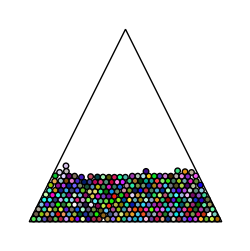

In [35]:
# New parameter to control frame skipping
skip_frames = 20  # Change this value to skip frames (e.g., 2 to skip every other frame). Makes animation speed up

# Prepare the figure and axes for plotting
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

# Calculate the bounding box of the triangle
min_x = min(triangle_scene.vertices[:, 0])
max_x = max(triangle_scene.vertices[:, 0])
min_y = min(triangle_scene.vertices[:, 1])
max_y = max(triangle_scene.vertices[:, 1])

factor = 0.1
ax.set_xlim(min_x - factor * triangle_scene.base, max_x + factor * triangle_scene.base)
ax.set_ylim(min_y - factor * triangle_scene.height, max_y + factor * triangle_scene.height)

# Draw triangle (walls)
triangle = Polygon(triangle_scene.vertices, fill=False, edgecolor='black', linewidth=1)
ax.add_patch(triangle)

# Draw grid
#draw_grid(ax=ax, scene_obj=triangle_scene)

# Create Circle patches for the particles
circles = []
for particle in triangle_scene.particles:
    circle = plt.Circle(particle.position, particle.radius, facecolor=particle.color, edgecolor='black', fill=True)
    ax.add_patch(circle)
    circles.append(circle)

ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal', 'box')
plt.axis('off')

# Adjust the number of frames based on the skip_frames parameter
adjusted_n_steps = n_steps // skip_frames

pbar = tqdm(total=adjusted_n_steps)

# Update function for the animation
def update(frame):
    # Adjust frame based on skip_frames
    frame = frame * skip_frames
    
    # For each particle, get the position from its path_history at the adjusted frame
    for i, particle in enumerate(triangle_scene.particles):
        if frame < len(particle.path_history):  # Ensure the frame doesn't exceed path_history length
            circles[i].center = particle.path_history[frame]  # Update position from path_history
    
    pbar.update(1)
    return circles


# Create the animation
ani = FuncAnimation(fig, update, frames=adjusted_n_steps, interval=30, blit=True)

# Save animation to file (optional)
ani.save(filename="examples/gravity_triangle_particle_simulation.gif", writer='pillow')

pbar.close()

# Simulate Double box

In [17]:
# Initialize rectangle scene
left_width, left_height = 5,5
right_width, right_height = 5,5
pipe_width, pipe_height = 2, 1
double_rectangle_scene = DoubleRectangle(left_dims=(left_height,left_height), 
                                         right_dims=(right_width,right_height),
                                         pipe_dims=(pipe_width,pipe_height),
                                         vertical_gravity=0.0,
                                         restitution=1.0)

# Generate particles
num_particles = 300
radius_range = (0.1, 0.1)
density_range = (1, 1)

# Add particles to the rectangle scene
double_rectangle_scene.generate_particles(num_particles=num_particles, 
                                          radius_range=radius_range, 
                                          density_range=density_range, 
                                          location='left',
                                          speed_scaling=15,
                                          max_attempts=10000)

In [18]:
# Simulation parameters
n_steps = 10000
dt = 0.0001

for _ in tqdm(range(n_steps)):
    double_rectangle_scene.simulate(1, dt)

100%|██████████| 10000/10000 [02:08<00:00, 78.12it/s]


  0%|          | 2/500 [00:00<00:04, 107.68it/s]


KeyboardInterrupt: 

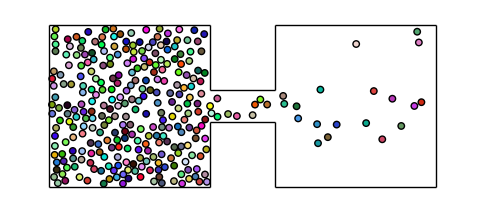

In [22]:
# New parameter to control frame skipping
skip_frames = 20  # Change this value to skip frames (e.g., 2 to skip every other frame). Makes animation speed up

# Prepare the figure and axes for plotting
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
factor = 0.1
wall_width = 1
total_width = left_width + pipe_width + right_width
max_height = max(left_height, right_height)
ax.set_xlim(0 - factor * total_width, total_width + factor * total_width)
ax.set_ylim(0 - factor * max_height, max_height+ factor * max_height)

# Draw the left container walls
ax.hlines(y=left_height, xmin=0, xmax=left_width, ls='-', lw=wall_width, color='black')  # top
ax.hlines(y=0, xmin=0, xmax=left_width, ls='-', lw=wall_width, color='black')  # bottom
ax.vlines(x=0, ymin=0, ymax=left_height, ls='-', lw=wall_width, color='black')  # left
ax.vlines(x=left_width, ymin=0, ymax=left_height/2-pipe_height/2, ls='-', lw=wall_width, color='black')  # right
ax.vlines(x=left_width, ymin=left_height/2+pipe_height/2, ymax=left_height, ls='-', lw=wall_width, color='black')  # right

# Draw the right container walls
ax.hlines(y=right_height, xmin=left_width + pipe_width, xmax=total_width, ls='-', lw=wall_width, color='black')  # top
ax.hlines(y=0, xmin=left_width + pipe_width, xmax=total_width, ls='-', lw=wall_width, color='black')  # bottom
ax.vlines(x=total_width, ymin=0, ymax=right_height, ls='-', lw=wall_width, color='black')  # right
ax.vlines(x=left_width+pipe_width, ymin=0, ymax=left_height/2-pipe_height/2, ls='-', lw=wall_width, color='black')  # right
ax.vlines(x=left_width+pipe_width, ymin=left_height/2+pipe_height/2, ymax=right_height, ls='-', lw=wall_width, color='black')  # right

# Draw the pip connecting the containers
ax.hlines(y=left_height/2+pipe_height/2, xmin=left_width,xmax=left_width+pipe_width, ls='-', lw=wall_width, color='black')  
ax.hlines(y=left_height/2-pipe_height/2, xmin=left_width,xmax=left_width+pipe_width, ls='-', lw=wall_width, color='black')  

# Draw grid
#draw_grid(ax=ax,scene_obj=double_rectangle_scene)

# Create Circle patches for the particles
circles = []
for particle in double_rectangle_scene.particles:
    circle = plt.Circle(particle.position, particle.radius, facecolor=particle.color, edgecolor='black', fill=True)
    ax.add_patch(circle)
    circles.append(circle)

ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal', 'box')
plt.axis('off')

# Adjust the number of frames based on the skip_frames parameter
adjusted_n_steps = n_steps // skip_frames

pbar = tqdm(total=adjusted_n_steps)

# Update function for the animation
def update(frame):
    # Adjust frame based on skip_frames
    frame = frame * skip_frames

    # For each particle, get the position from its path_history at the adjusted frame
    for i, particle in enumerate(double_rectangle_scene.particles):
        if frame < len(particle.path_history):  # Ensure the frame doesn't exceed path_history length
            circles[i].center = particle.path_history[frame]  # Update position from path_history
    pbar.update(1)
    return circles


# Create the animation
ani = FuncAnimation(fig, update, frames=adjusted_n_steps, interval=30, blit=True)

# Save animation to file (optional)
ani.save(filename="examples/double_rectangle_particle_simulation.gif", writer='pillow')

pbar.close()

0.01755690574645996 187


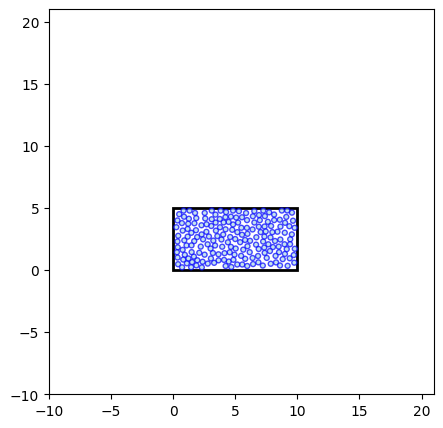

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import math
from time import time
from collections import deque

from src.tools import *

# Assume that distance, poisson_disk_sampling_strict_no_overlap, can_fit_circles, is_point_in_shape,
# and get_shape_bounding_box functions are already defined from earlier.

# Define some example shapes: rectangle, triangle, polygon, and circle

# 1. Rectangle shape (x, y, width, height)
rectangle = ('rectangle', (0, 0, 10, 5))

# 2. Triangle shape (p1, p2, p3)
triangle = ('triangle', [(2, 2), (7, 1), (5, 6)])

# 3. Polygon shape (arbitrary polygon with vertices)
polygon = ('polygon', [(2, 2), (7, 1), (9, 6), (4, 8), (1, 5)])

# 4. Circle shape (center_x, center_y, radius)
circle = ('circle', (5,5, 10))

# Example: Poisson disk sampling in a shape
N = 500  # Number of circles
radii = [random.uniform(0.2, 0.2) for _ in range(N)]  # Random circle radii

# Let's use the circle shape for demonstration
chosen_shape = rectangle

# Perform Poisson Disk Sampling to pack circles in the shape
a = time()
packed_circles = poisson_disk_sampling_strict_no_overlap(N, radii, chosen_shape)
b = time()
print(b-a, len(packed_circles))
# Plot the result
fig, ax = plt.subplots(1,1,figsize=(5,5))

# Draw the shape
if chosen_shape[0] == 'rectangle':
    rect = patches.Rectangle(chosen_shape[1][:2], chosen_shape[1][2], chosen_shape[1][3], linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(rect)
elif chosen_shape[0] == 'triangle':
    triangle_points = chosen_shape[1]
    polygon_patch = patches.Polygon(triangle_points, closed=True, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(polygon_patch)
elif chosen_shape[0] == 'polygon':
    polygon_points = chosen_shape[1]
    polygon_patch = patches.Polygon(polygon_points, closed=True, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(polygon_patch)
elif chosen_shape[0] == 'circle':
    circle_center, circle_radius = chosen_shape[1][0:2], chosen_shape[1][2]
    circle_patch = patches.Circle(circle_center, circle_radius, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(circle_patch)

# Plot the packed circles
for (x, y, radius) in packed_circles:
    circle = patches.Circle((x, y), radius, edgecolor='blue', facecolor='lightblue', alpha=0.7)
    ax.add_patch(circle)

# Set equal aspect ratio and limits
ax.set_aspect('equal')
ax.set_xlim(-10, 21)
ax.set_ylim(-10, 21)
plt.show()
